## 課題

以下のような状況を仮定します;  
>あなたは、ITコンサルティング会社の若手アソシエイトです。  
先日、チームのマネージャーが、とある電気通信事業会社A社からデータ分析のPoCを受注してきました。  
聞くところによると、A社には機械学習に詳しい人材はおらず、長年に渡り蓄積したデータをどのように事業に活かせばよいのかを苦慮しているとのことです。  
今回のPoCでは、**機械学習を用いて提供されたデータを分析することで、A社の課題を設定し、これを解決する新規事業の内容・効果を示します**。  
A社としては、DX戦略の一環として**新規事業の中にも機械学習を応用したい**と考えているようですが、PoCの現段階では必須ではありません。  
アソシエイトであるあなたは、約2ヶ月後のA社とのミーティングで、**データ分析と機械学習の結果に基づく新規事業を提案するプレゼン**をしなければなりません。  
分析と提案次第では、A社と正式にコンサルティング契約を結ぶことができ、あなたは、機械学習を用いた事業開発を主導することができるでしょう。

※PoCとは、新しい技術・アイデアを完全に実用化する前に、それが実現可能であるか、目的が達成できるかなどの要件を確認するための実験的な検証のことです。PoCの結果、提案が要件を満たす場合に、実用可能なシステムの開発や詳細な事業戦略の策定にステップアップできます。

以上を踏まえて、以下の要件を満たす事業モデルについての資料を提出してください。

## ヒント
**- 目的変数について**  
題材となっているコンペティションでは解約の有無を目的変数としていますが，最終課題では自由に目的変数を設定して構いません。


**- 何を求められるのか？**  
与えられたデータから収益を上げるための事業を考えます。その際に評価されるのは、事業提案の必然性の論理と事業規模の適切な推定です。


**- 事業を提案するまで**  
以下に，事業を提案するまでの一例を挙げます;
1. データ探索 + 可視化
2. 課題となる変数を設定し、モデルをいくつか開発
3. 開発したモデルをもとに、事業を提案
4. 考えた事業の必要性，規模等を概算


**- 資料作成の注意点**  
要件にあるように，作成した資料は機械学習に関して事前知識をもたない人に対するものです。そのため専門用語の濫用やソースコードのコピー&ペースト等は著しく評価が低くなる可能性があります。

## 事業を提案するまでの一例
1. データ探索 + 可視化
2. 課題となる変数を設定し、モデルをいくつか開発
3. 開発したモデルをもとに、事業を提案
4. 考えた事業の必要性，規模等を概算

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_columns',100)
pd.set_option('Display.max_rows',100)

## Import Dataset

In [5]:
# Read csv file
path    = "../final_assignment_public/Telecom_customer_churn.csv"
df      = pd.read_csv( path )

print( 'df:\n{} rows × {} columns\n'.format( df.shape[0], df.shape[1] ) )

df:
100000 rows × 100 columns



## Data Preprocessing

In [6]:
def check_null( _df ):
    print( _df.isnull().sum() )

### Feature engineering

In [7]:
# # 1日あたりの端末料金(使い倒せているか)
# df['hnd_price_per_day'] = df['hnd_price'] / df['eqpdays']

# # 1日あたりの通話数
# df['calls_per_day'] = df['totcalls'] / df['eqpdays']

# # 端末価格が収入に対して占める割合
# df['hnd_price_ratio'] = df['hnd_price'] / df['rev_Mean']

### Numerical data

In [8]:
# 数値変数を確認
numerical = df[df.select_dtypes( exclude=object ).columns]
x_num = numerical.columns

# 欠損値を0で埋める
numerical = numerical.fillna(0)
# check_null( numerical )

# 反映
df[x_num] = numerical

### Categorical data encoding

In [9]:
# カテゴリカル変数を確認
categorical = df[df.select_dtypes( include=object ).columns]
x_cat = categorical.columns

In [10]:
# 欠損値がある行を落とす
df_nona = df.dropna( axis=0 )

In [11]:
# For Categorical data, converted to numerical using Label Encoder. 
# By this method, all categorical data are sorted by alphabetically.
for x in x_cat:
    df_nona[x] = LabelEncoder().fit_transform( df_nona[x] )

In [12]:
display( df_nona )

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.0,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.000000,42.333333,0.0,45.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.000000,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.000000,132.600000,0.000000,24.000000,0.0,55.220000,0.0,1.333333,52.333333,45.000000,0.0,0.333333,1,61,2,1,1,0,0,1652,4228.00,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,2,13,3,0,149.98999,2.0,2.0,2,0.0,0.0,0,15.0,1,3,1.0,0,4.0,3.0,2,0,0.0,8,0,0,0,0,0,1,361.0,1000001
4,55.2300,570.50,71.980,0.0000,0.0,0.0,0.0,0.0,0.0,38.50,0.0000,9.666667,0.0,0.666667,0.0,77.000000,0.0,222.333333,0.000000,94.666667,0.0,137.000000,0.000000,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,0.000000,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.000000,173.476667,0.000000,90.333333,0.0,218.086667,0.0,10.333333,222.333333,137.000000,0.0,0.000000,0,57,1,1,2,0,0,4485,14028.00,2181.12,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,4,10,3,0,149.98999,6.0,4.0,2,0.0,0.0,1,5.0,0,3,1.0,0,6.0,1.0,2,14,0.0,5,0,0,0,0,0,1,434.0,1000005
9,31.6625,25.50,29.990,0.2475,0.0,0.0,0.0,0.0,0.0,59.50,4.0275,0.000000,0.0,1.000000,0.0,2.333333,0.0,6.666667,0.000000,0.000000,0.0,3.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.666667,0.000000,1.866667,0.000000,1.666667,0.0,1.933333,0.0,1.000000,6.666667,3.333333,0.0,0.000000,0,57,2,2,0,0,0,391,994.00,1458.42,1457.84,976.00,377,26.51,17.75,6.85,6,3,30,54.0,7.0,34.0,0,4,3,0,79.98999,2.0,2.0,2,0.0,0.0,0,8.0,1,2,2.0,0,9.0,2.0,5,0,1.0,8,0,0,0,0,0,1,601.0,1000010
10,62.1275,97.50,65.985,2.4750,0.0,0.0,0.0,0.0,0.0,23.50,6.8225,0.000000,0.0,0.333333,0.0,4.000000,0.0,19.333333,0.333333,0.000000,0.0,15.000000,0.333333,4.000000,98.666667,96.920000,0.000000,0.000000,136.493333,0.056667,0.000000,3.666667,15.366667,0.000000,0.000000,7.666667,0.333333,66.073333,0.056667,7.333333,0.0,70.420000,0.0,0.333333,19.666667,15.333333,0.0,0.000000,0,59,2,2,2,0,0,2392,6868.11,3290.73,3195.01,6620.11,2312,56.05,116.14,40.56,90,16,60,123.0,32.0,64.0,0,4,3,0,79.98999,3.0,3.0,2,0.0,0.0,0,15.0,1,3,5.0,0,6.0,0.0,2,0,0.0,8,1,0,0,0,0,1,464.0,1000011
12,81.0000,1056.25,75.000,0.0000,0.0,0.0,0.0,0.0,0.0,42.75,2.3500,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0,55,1,1,2,5,0,31584,51857.07,4270.87,4181.91,51553.07,31397,78.90,972.70,592.40,1042,625,80,999.0,625.0,76.0,4,6,3,0,199.98999,9.0,5.0,2,0.0,0.0,0,15.0,1,3,3.0,0,5.0,0.0,1,0,0.0,6,0,0,0,0,0,1,388.0,1000013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

## Train Test Split

In [13]:
# y = df['churn']
# X_train, X_test, y_train, y_test = train_test_split( df, y, random_state=1 )

# churnを目的変数に設定
y_train = df_nona['churn']

# 目的変数以外を取得
X_train = df_nona.drop( columns=['churn'] )

In [14]:
# LightGBM parameters

# lgbm_params = {
#         'reg_lambda': 0.06875461198761648, 
#         'reg_alpha': 2.2293651627955215, 
#         'colsample_bytree': 0.7208495854217002, 
#         'subsample': 0.781401201566485, 
#         'max_depth': 8, 
#         'min_child_weight': 3.109569481392587
# }

# lgbm_params = {
#         'boosting_type': 'gbdt',
#         'objective': 'regression',
#         'metric': 'rmse',
#         'max_depth': 5,
#         'min_data_in_leaf': 20,
#         'min_child_weight': 3,
#         'feature_fraction': 1.0,
#         'min_data_in_leaf': 20,
#         'num_iterations': 100,
#         'seed': 0,
#         'verbose': -1,
#         'reg_lambda': 0.07, 
#         'reg_alpha': 2.23, 
#         'colsample_bytree': 0.72, 
#         'subsample': 0.78
# }

# model_lgbm = LGBMClassifier(
#         boosting_type='gbdt', 
#         class_weight='balanced',
#         reg_lambda=1.1564659040946654, 
#         reg_alpha=9.90877329623665,
#         colsample_bytree=0.5034991685866442, 
#         subsample=0.6055998601661783, 
#         max_depth=5,
#         min_child_weight=39.72586351155486, 
#         learning_rate=0.0732489659779158,
#         num_threads=1 )

# LightGBM model
model = LGBMClassifier(
        boosting_type='gbdt', 
        class_weight='balanced',
        max_depth=10,
        num_threads=1 )

In [15]:
model.fit( X_train, y_train )

[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(class_weight='balanced', max_depth=10, num_threads=1)

### 重要度の確認

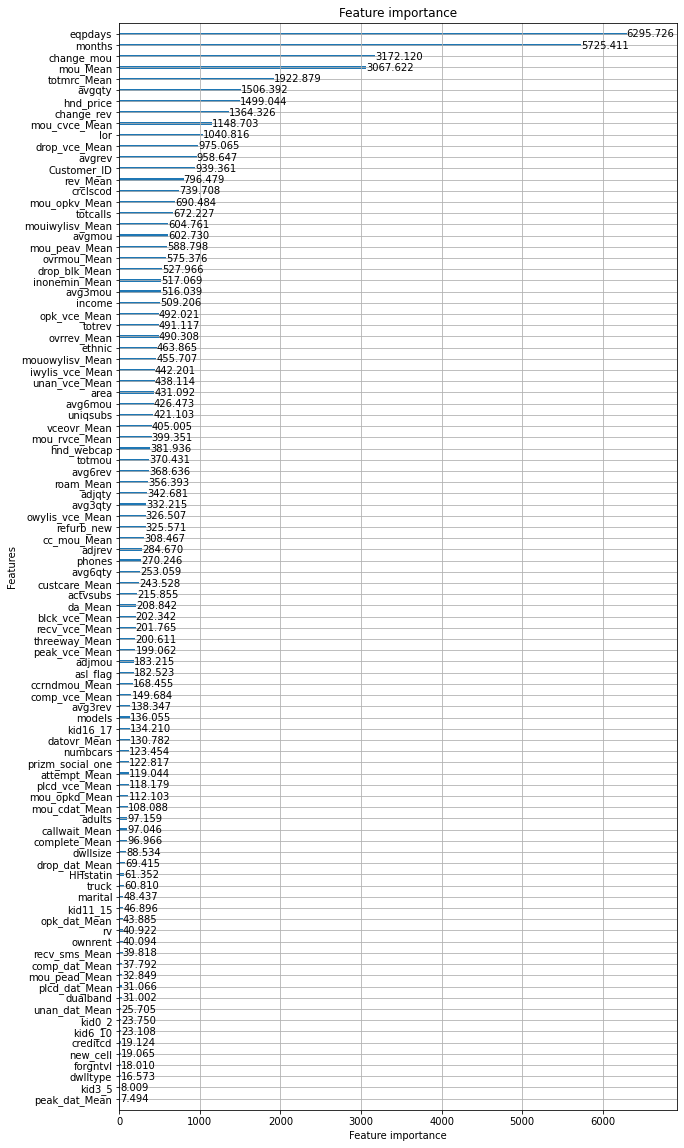

In [16]:
lgbm.plot_importance( model, importance_type="gain", max_num_features=110, figsize=(10, 20) )

### 重要度が高いカラムを抽出

In [14]:
# 特徴量のカラム名を取得
f_name = model.feature_name_

# 特徴量の値を正規化
f_imp = model.booster_.feature_importance( importance_type='gain' )
f_imp = f_imp / np.sum( f_imp )

# dfを作成
df_imp = pd.DataFrame( {'feature':f_name, 'importance':f_imp} )
df_imp = df_imp.sort_values( 'importance', ascending=False )

# インデックスを振り直す
df_imp = df_imp.reset_index()

display( df_imp )

,index,feature,importance
0,97,eqpdays,0.174813
1,48,months,0.157756
2,9,change_mou,0.067828
3,1,mou_Mean,0.059043
4,2,totmrc_Mean,0.041318
5,73,hnd_price,0.032973
6,62,avgqty,0.030504
7,80,lor,0.025559
8,28,mou_cvce_Mean,0.019922
9,10,change_rev,0.019726


In [15]:
# 累積重要度
# 上位22個のデータが，結果の80%を占めている．
def calc_cum_imp():
    tmp_sum = 0
    f_core_th = 0
    cum_imp = []
    for i in range( df_imp['importance'].size ):
        tmp_sum += df_imp['importance'][i]
        cum_imp.append( tmp_sum )

        if tmp_sum < 0.8:
            f_core_th = i+1

    return f_core_th, cum_imp

In [16]:
f_core_th, cum_imp = calc_cum_imp()

In [17]:
df_imp['cum_imp'] = cum_imp

In [18]:
df_imp_core = df_imp[:f_core_th]
df_imp_core

,index,feature,importance,cum_imp
0,97,eqpdays,0.174813,0.174813
1,48,months,0.157756,0.332569
2,9,change_mou,0.067828,0.400398
3,1,mou_Mean,0.059043,0.459440
4,2,totmrc_Mean,0.041318,0.500758
5,73,hnd_price,0.032973,0.533731
6,62,avgqty,0.030504,0.564235
7,80,lor,0.025559,0.589794
8,28,mou_cvce_Mean,0.019922,0.609716
9,10,change_rev,0.019726,0.629442


In [19]:
df_imp_core['feature'].to_csv( '../csv/f_imp_core.csv' )

In [22]:
def plot_cum_imp():
    plt.rcParams["figure.figsize"] = (24, 10)
    # plt.title( 'Cumulative Feature Importance', fontsize=24 )

    x = df_imp['feature']
    y = df_imp['cum_imp']
    plt.plot( x, y, marker="o", color='black' )
    # plt.hlines( 0.8, 0, 99, "red", linestyles='dashed')
    plt.xticks( range( df_imp['feature'].size ), x, rotation=90, fontsize=10 )
    plt.yticks( [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=18 )
    plt.ylabel( 'Cumulative feature importance', fontsize=18 )
    plt.show()

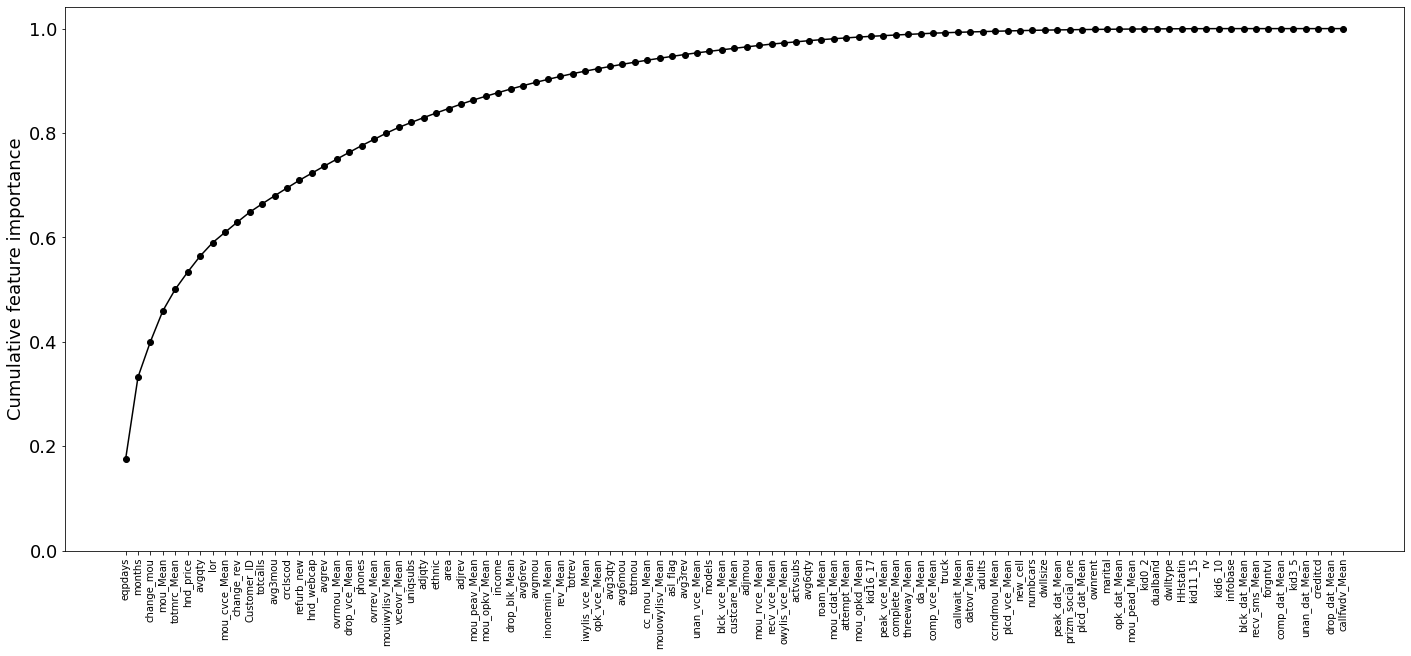

In [23]:
plot_cum_imp()